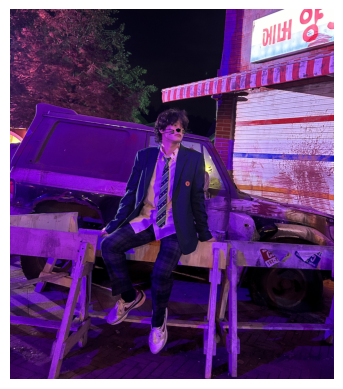

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# 1) 경로 설정
home_dir      = os.getenv('HOME')
image_path    = os.path.join(home_dir, 'work/camera_sticker/images/small_face.png')
model_path    = os.path.join(home_dir, 'work/camera_sticker/models/shape_predictor_68_face_landmarks.dat')
sticker_path  = os.path.join(home_dir, 'work/camera_sticker/images/mustache.png')

# 2) 이미지 로드
img_bgr  = cv2.imread(image_path)
img_show = img_bgr.copy()
img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 3) 얼굴 검출기·랜드마크 모델 초기화
detector  = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_path)

# 4) 콧수염 스티커 로드 (알파 채널 포함 가정)
sticker_orig = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)

# 5) 얼굴 검출
rects = detector(img_rgb, 1)

for rect in rects:
    # 6) 랜드마크 추출
    shape = predictor(img_rgb, rect)
    lm    = [(p.x, p.y) for p in shape.parts()]

    # 7) 스티커 크기 계산 (입꼬리 간 거리×1.2에 4배 확대)
    left_mouth, right_mouth = lm[48], lm[54]
    w = int((right_mouth[0] - left_mouth[0]) * 1.2 * 4)
    h = int(w * sticker_orig.shape[0] / sticker_orig.shape[1])
    sticker = cv2.resize(sticker_orig, (w, h), interpolation=cv2.INTER_AREA)

    # 8) 위치 계산 (코 중앙에서 두 칸 아래 lm[32])
    nose_center = lm[32]
    x = nose_center[0] - w // 2
    y = nose_center[1] - h // 2

    # 9) 화면 밖 벗어남 보정
    if x < 0:
        sticker = sticker[:, -x:]
        x = 0
    if y < 0:
        sticker = sticker[-y:, :]
        y = 0
    if y + sticker.shape[0] > img_show.shape[0]:
        overflow = y + sticker.shape[0] - img_show.shape[0]
        sticker = sticker[:sticker.shape[0]-overflow, :]
    if x + sticker.shape[1] > img_show.shape[1]:
        overflow = x + sticker.shape[1] - img_show.shape[1]
        sticker = sticker[:, :sticker.shape[1]-overflow]

    # 10) 합성
    overlay = img_show[y:y+sticker.shape[0], x:x+sticker.shape[1]]
    if sticker.shape[2] == 4:
        alpha = sticker[:, :, 3:] / 255.0
        overlay[:] = alpha * sticker[:, :, :3] + (1 - alpha) * overlay
    else:
        overlay[:] = np.where(sticker[:, :, :3] == 0, overlay, sticker)
    img_show[y:y+sticker.shape[0], x:x+sticker.shape[1]] = overlay.astype(np.uint8)

# 11) 결과 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
